In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
e1 = pd.read_csv('./completeSpamAssassin.csv')
e2 = pd.read_csv('./enronSpamSubset.csv')
e3 = pd.read_csv('./lingSpam.csv')

In [3]:
email = pd.concat([e1, e2, e3], axis=0)

In [9]:
email.head()

,Unnamed: 0,Body,Label,Unnamed: 0.1
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,NaN
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,NaN
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,NaN
3,3,##############################################...,1,NaN
4,4,I thought you might like these:\n1) Slim Down ...,1,NaN


In [ ]:
import re
import nltk

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Define a function to preprocess the text
def preprocess_text(text):
    if isinstance(text, str):  # Check if the value is a string
        # Lowercase text
        text = text.lower()

        # Remove punctuation
        text = re.sub('[^\w\s]', '', text)

        stopwords_set = set(stopwords.words('english'))
        text = ' '.join([word for word in nltk.word_tokenize(text) if word not in stopwords_set])

        # Stemming
        stemmer = PorterStemmer()
        text = ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(text)])

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])

    return text

In [ ]:
# Apply the preprocess_text function to the 'Body' column
email['Body'] = email['Body'].apply(preprocess_text)

In [ ]:
# Split your data into features (X) and labels (y)
X = email['Body']
y = email['Label']

In [ ]:
# Encode the labels using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
email['Body'].fillna('', inplace=True)

In [ ]:
# Define TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the text data into TF-IDF vectors
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [ ]:
# Define the individual models
svc_model = SVC(probability=True)
rf_model = RandomForestClassifier()
nb_model = MultinomialNB()

In [ ]:
# Create a list of tuples where each tuple contains a model and its name
estimators = [
    ('svc', svc_model),
    ('random_forest', rf_model),
    ('naive_bayes', nb_model)
]

In [ ]:
# Create a StackingClassifier with a meta-classifier (Logistic Regression)
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()  # You can use another classifier as the meta-classifier
)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Fit the stacking ensemble model on the training data
stacking_classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('svc', SVC(probability=True)),
                               ('random_forest', RandomForestClassifier()),
                               ('naive_bayes', MultinomialNB())],
                   final_estimator=LogisticRegression())

In [ ]:
# Make predictions using the stacking ensemble model
y_pred = stacking_classifier.predict(X_test)

In [1]:
from sklearn.metrics._plot.roc_curve import roc_curve
import matplotlib.pyplot as plt
def plot_roc_curve(y_test, y_pred) :
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')


Model: Stacking Ensemble Model
Accuracy: 0.9740016081479496
Precision: 0.956373551465576
Recall: 0.9770194986072424
F1 Score: 0.9665862900447812


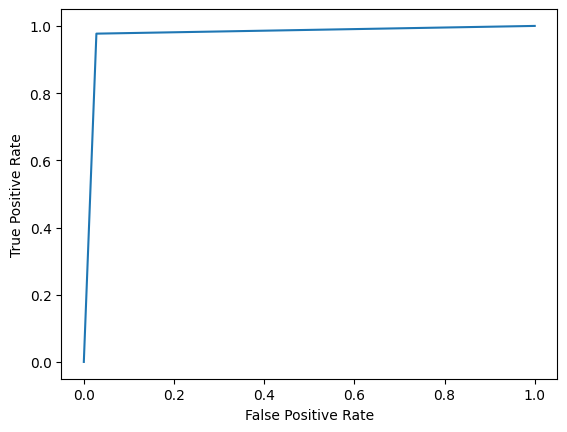

In [ ]:
# Evaluate the stacking ensemble model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

model_name = "Stacking Ensemble Model"
print(f"Model: {model_name}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
plot_roc_curve(y_test, y_pred)

In [ ]:
# # Use k-fold cross-validation for evaluation
# scoring = 'accuracy'
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_val_score(stacking_classifier, X_tfidf, y_encoded, cv=kfold, scoring=scoring)
# mean_accuracy = np.mean(results)
# print(f"Mean Accuracy (k-fold): {mean_accuracy}")

In [ ]:
# Prediction function
def predict_spam(input_text):
    # Preprocess the input text
    input_text = input_text.lower()
    input_text = re.sub('[^\w\s]', '', input_text)
    input_text = ' '.join([word for word in nltk.word_tokenize(input_text) if word not in set(stopwords.words('english'))])
    input_text = ' '.join([PorterStemmer().stem(word) for word in nltk.word_tokenize(input_text)])
    input_text = ' '.join([WordNetLemmatizer().lemmatize(word) for word in nltk.word_tokenize(input_text)])

    # Convert the preprocessed text into the same feature representation used for training
    input_feature = tfidf_vectorizer.transform([input_text])

    # Use the trained model to make a prediction
    prediction = stacking_classifier.predict(input_feature)

    # Output the prediction result
    if prediction[0] == 1:
        return "This is a spam email."
    else:
        return "This is not a spam email."

# Example usage
input_text = input("Enter the email text: ")
result = predict_spam(input_text)
print(result)

Enter the email text: You will have to appear at the allotted exam center and produce your Hall ticket and Government Photo Identification Card (Example: Driving License, Passport, PAN card, Voter ID, Aadhaar-ID with your Name, date of birth, photograph and signature) for verification and take the exam in person. You can find the final allotted exam center details in the hall ticket.  The hall ticket is yet to be released. We will notify the same through email and SMS.  Type of exam: Computer based exam (Please check in the above list corresponding to your course name)  The questions will be on the computer and the answers will have to be entered on the computer; type of questions may include multiple choice questions, fill in the blanks, essay-type answers, etc.  Type of exam: Paper and pen Exam (Please check in the above list corresponding to your course name)  The questions will be on the computer. You will have to write your answers on sheets of paper and submit the answer sheets. 